# LIBRARY

In [22]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import date, datetime
from multiprocessing.spawn import import_main_path
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D




# GET DATA

In [23]:
tickers = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
# end_date = '2022-08-02'

panel_data = data.DataReader(tickers,'yahoo',start_date,today)
panel_data.head(5)


Attributes    Adj Close                                               Close  \
Symbols         ANTM.JK      ASII.JK      ICBP.JK      JSMR.JK      ANTM.JK   
Date                                                                          
2010-01-04  1576.277344  2454.148926  1408.558960  1530.937744  1931.946777   
2010-01-05  1576.277344  2468.053223  1437.305176  1547.488647  1931.946777   
2010-01-06  1576.277344  2454.148926  1427.723267  1555.763916  1931.946777   
2010-01-07  1610.543945  2377.674316  1437.305176  1547.488647  1973.945557   
2010-01-08  1610.543945  2391.578613  1446.886963  1539.213135  1973.945557   

Attributes                                      High          ...     Low  \
Symbols    ASII.JK ICBP.JK      JSMR.JK      ANTM.JK ASII.JK  ... ICBP.JK   
Date                                                          ...           
2010-01-04  3530.0  1837.5  1845.677368  1931.946777  3550.0  ...  1762.5   
2010-01-05  3550.0  1875.0  1865.630737  1994.945068  3570.0  ...  1825.0   
2010-01-06  3530.0  1862.5  1875.607300  1994.945068  3580.0  ...  1862.5   
2010-01-07  3420.0  1875.0  1865.630737  1994.945068  3560.0  ...  1862.5   
2010-01-08  3440.0  1887.5  1855.654053  1994.945068  3450.0  ...  1862.5   

Attributes                      Open                                   Volume  \
Symbols         JSMR.JK      ANTM.JK ASII.JK ICBP.JK      JSMR.JK     ANTM.JK   
Date                                                                            
2010-01-04  1805.770874  1931.946777  3530.0  1787.5  1845.677368  39619544.0   
2010-01-05  1845.677368  1931.946777  3550.0  1875.0  1865.630737  62041590.0   
2010-01-06  1855.654053  1931.946777  3530.0  1900.0  1875.607300  30916328.0   
2010-01-07  1845.677368  1973.945557  3420.0  1875.0  1865.630737  30624653.0   
2010-01-08  1845.677368  1973.945557  3440.0  1900.0  1855.654053  15857579.0   

Attributes                                 
Symbols    ASII.JK     ICBP.JK    JSMR.JK  
Date                                       
2010-01-04    40.0  26442000.0  6978806.0  
2010-01-05    40.0  42874000.0  7988164.0  
2010-01-06    40.0  44946000.0  7538113.0  
2010-01-07    40.0  24863000.0  2048787.0  
2010-01-08    40.0  19118000.0  2441705.0  

[5 rows x 24 columns]

In [24]:
data_close = panel_data["Adj Close"]
data_close.head(5).round(2)
list(data_close)
data_close.columns = ['antm', 'asii', 'icbp', 'jsmr']
data_close

,antm,asii,icbp,jsmr
Date,,,,
2010-01-04,1576.277344,2454.148926,1408.558960,1530.937744
2010-01-05,1576.277344,2468.053223,1437.305176,1547.488647
2010-01-06,1576.277344,2454.148926,1427.723267,1555.763916
2010-01-07,1610.543945,2377.674316,1437.305176,1547.488647
2010-01-08,1610.543945,2391.578613,1446.886963,1539.213135
...,...,...,...,...
2022-08-10,2120.000000,6850.000000,8725.000000,3450.000000
2022-08-11,2240.000000,6950.000000,8875.000000,3550.000000
2022-08-12,2220.000000,6950.000000,8675.000000,3490.000000


# Normalize data

In [25]:
from sklearn.preprocessing import MinMaxScaler
def normalize_data(df_data, COLUMN_NAME):
    scaler = MinMaxScaler()
    df_data = pd.DataFrame(df_data)
    df_data = pd.DataFrame(scaler.fit_transform(df_data), columns = [COLUMN_NAME])
    return df_data


In [26]:
df_asii = normalize_data(data_close.asii,'asii')
df_icbp = normalize_data(data_close.icbp, 'icbp')
df_jsmr = normalize_data(data_close.jsmr, 'jsmr')

# SLIDING WINDOW FUNCTION

In [27]:
from numpy import array

def split_sequence(seq, n_steps):
    X,y = list(), list()
    for i in range(len(seq)):
        end_ix = i + n_steps
        if end_ix > len(seq)-1:
            break
        seq_x, seq_y =seq[i:end_ix],seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# RESET INDEX FUNCTION

In [28]:
from sklearn.model_selection import train_test_split
def reset_index_data(df_data):
    df_data = df_data.reset_index(drop=True)
    arr_df = df_data.to_numpy()
    flat_df = arr_df.flatten()
    return flat_df

# RESHAPE DATA FUNC

In [29]:
def reshape_data(X,N_FEATURES):
    X = X.reshape(X.shape[0],X.shape[1],N_FEATURES)
    return X

# TRAIN VANILA MODEL FUCTION

In [30]:
def train_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

In [31]:
def train_vanila_lstm(X_train,y_train,config):
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_vanila_lstm = Sequential([
    LSTM(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_vanila_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_vanila_lstm.summary()
    history_vanila_lstm = model_vanila_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_vanila_lstm, history_vanila_lstm

#time 41.8
    

# MATRICS EVALUTE

In [32]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
def matriks_evaluate(preds,y_test, lb_saham):
    print('Matriks score for '+ lb_saham)
    print("mae score: "+str(mean_absolute_error(preds, y_test)))
    print("r2 score "+str(r2_score(preds, y_test)))
    print("mape score "+str(mean_absolute_percentage_error(preds, y_test)))
    print("rmse score "+str(np.sqrt(mean_squared_error(preds, y_test))))

# ROUNDUP FUNCTION

In [33]:
def pembulatan(data,number):
    print(np.round(data,number))

# VANILA LSTM

## ANTM

In [34]:
#get data and normalize data
df_antm = normalize_data(data_close.antm,'antm')
#reset index
df_antm = reset_index_data(df_antm)
#data to supervised
antm_X, antm_y = split_sequence(df_antm, 2)
#split to train and test
X_train_antm, X_test_antm, y_train_antm, y_test_antm = train_test_split(antm_X, antm_y, test_size=0.33, random_state=42)

X_train_antm = reshape_data(X_train_antm,1)
X_test_antm = reshape_data(X_test_antm,1)


In [35]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_antm,history_antm_model,  = train_vanila_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 8)                 320       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 2s 3ms/step - loss: 0.0401 - mae: 0.0401 - val_loss: 0.0157 - val_mae: 0.0157
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0097 - val_mae: 0.0097
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0223 - val_mae: 0.0223
Epoch 4/200
210/210 [==============================] 

In [36]:
preds_antm = model_antm.predict(X_test_antm)
matriks_evaluate(preds_antm,y_test_antm,'antm')

Matriks score for antm
mae score: 0.008427343064168029
r2 score 0.9949248850014537
mape score 0.03923833907975796
rmse score 0.014365594326758126


In [218]:
# Matriks score for antm
pembulatan(0.007934620954499606,2)
pembulatan(0.9957026171046904,2)
pembulatan(0.04075884954250871,2)
pembulatan(0.01301039855428923,2)

0.01
1.0
0.04
0.01


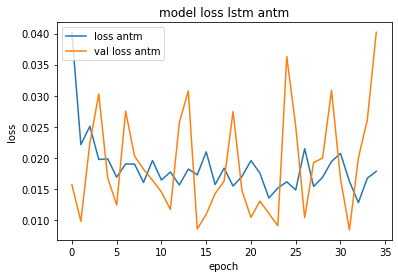

In [38]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm', dpi=3600)

## ASII

In [39]:
#get data and normalize data
df_asii = normalize_data(data_close.asii,'asii')
#reset index
df_asii = reset_index_data(df_asii)
#data to supervised
asii_X, asii_y = split_sequence(df_asii, 3)
#split to train and test
X_train_asii, X_test_asii, y_train_asii, y_test_asii = train_test_split(asii_X, asii_y, test_size=0.33, random_state=42)

X_train_asii = reshape_data(X_train_asii,1)
X_test_asii = reshape_data(X_test_asii,1)


In [40]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_asii,history_asii_model,  = train_vanila_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 3s 4ms/step - loss: 0.0398 - mae: 0.0398 - val_loss: 0.0178 - val_mae: 0.0178
Epoch 2/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 3/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0221 - mae: 0.0221 - val_loss: 0.0183 - val_mae: 0.0183
Epoch 4/150
210/210 [============================

In [41]:
preds_asii = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii,y_test_asii,'asii')

Matriks score for asii
mae score: 0.015152538495704002
r2 score 0.9899739556162052
mape score 0.03352378584491088
rmse score 0.019901445064021188


In [219]:
# Matriks score for asii
pembulatan(0.014477178205400888,2)
pembulatan(0.9906708116313951,2)
pembulatan(0.03233571113583237,2)
pembulatan(0.019196850071116774,2)

0.01
0.99
0.03
0.02


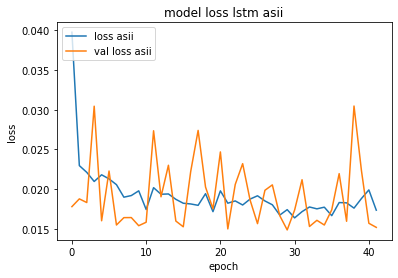

In [43]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii', dpi=3600)

## ICBP


In [44]:
#get data and normalize data
df_icbp = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp = reset_index_data(df_icbp)
#data to supervised
icbp_X, icbp_y = split_sequence(df_icbp, 1)
#split to train and test
X_train_icbp, X_test_icbp, y_train_icbp, y_test_icbp = train_test_split(icbp_X, icbp_y, test_size=0.33, random_state=42)

X_train_icbp = reshape_data(X_train_icbp,1)
X_test_icbp = reshape_data(X_test_icbp,1)


In [45]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_icbp,history_icbp_model,  = train_vanila_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8)                 320       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 3s 6ms/step - loss: 0.1481 - mae: 0.1481 - val_loss: 0.0196 - val_mae: 0.0196
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0176 - mae: 0.0176 - val_loss: 0.0168 - val_mae: 0.0168
Epoch 4/200
105/105 [==============================] 

In [46]:
preds_icbp = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007997358211912574
r2 score 0.9981225345901428
mape score 0.031065277983877787
rmse score 0.012033815222868439


In [220]:
# Matriks score for icbp
pembulatan(0.007518278165003873
,2)
pembulatan(0.9980980760462315,2)
pembulatan(0.03298193863122954,2)
pembulatan(0.01215460388750067,2)

0.01
1.0
0.03
0.01


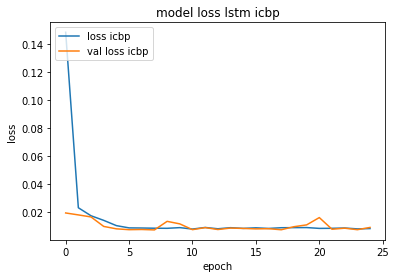

In [48]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp', dpi=3600)

## JSMR

In [49]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


In [50]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_jsmr,history_jsmr_model,  = train_vanila_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 320       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 5ms/step - loss: 0.1704 - mae: 0.1704 - val_loss: 0.0477 - val_mae: 0.0477
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0211 - mae: 0.0211 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 4/200
105/105 [==============================] 

In [51]:
preds_jsmr = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011882986257626781
r2 score 0.9939668858325574
mape score 0.029697933156437987
rmse score 0.016611244844292602


In [221]:
# Matriks score for icbp
pembulatan(0.01245784884301439
,2)
pembulatan(0.9933417201919836,2)
pembulatan(0.038401239119610214,2)
pembulatan(0.01734341193766076,2)

0.01
0.99
0.04
0.02


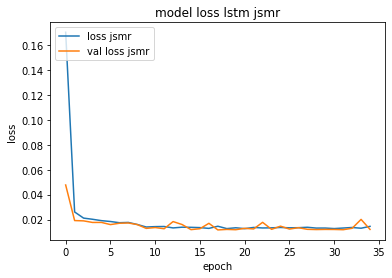

In [53]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr', dpi=3600)

# BIDIRECTIONAL LSTM

In [54]:
def train_bidirectional_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_bidirectional_lstm = Sequential([
    Bidirectional(LSTM(neuron, activation=activation),input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_bidirectional_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_bidirectional_lstm.summary()
    history_bidirectional_lstm = model_bidirectional_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_bidirectional_lstm, history_bidirectional_lstm

#time 41.8
    

## ANTM

In [55]:
cfg_antm = [8,'relu',2,1,0.1,8,200]
model_bidirectional_antm,history_antm_model_bidirectional,  = train_bidirectional_lstm(X_train_antm,y_train_antm,cfg_antm)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16)               640       
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 3s 5ms/step - loss: 0.0449 - mae: 0.0449 - val_loss: 0.0606 - val_mae: 0.0606
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0167 - val_mae: 0.0167
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0199 - mae: 0.0199 - val_loss: 0.0100 - val

In [56]:
preds_antm_bidirectional = model_bidirectional_antm.predict(X_test_antm)
matriks_evaluate(preds_antm_bidirectional,y_test_antm,'antm')

Matriks score for antm
mae score: 0.010488952498763216
r2 score 0.9940892733454582
mape score 0.05216139668163591
rmse score 0.01594476119329387


In [57]:
# Matriks score for antm
# mae score: 0.008232755712539704
# r2 score 0.9956862906506637
# mape score 0.04528757310273332
# rmse score 0.013190786339141062

In [58]:
# Matriks score for icbp
pembulatan(0.008232755712539704
,4)
pembulatan(0.9956862906506637,4)
pembulatan(0.04528757310273332,4)
pembulatan(0.013190786339141062,4)

0.0082
0.9957
0.0453
0.0132


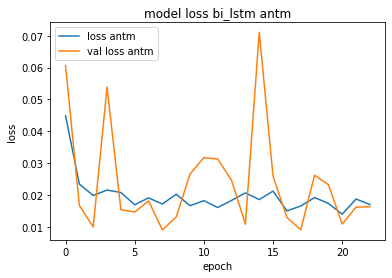

In [59]:
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['val_loss'], label = 'val loss antm')
plt.title('model loss bi_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_bidirection', dpi=3600)

## ASII

In [60]:
cfg_asii = [32,'relu',3,1,0.01,8,150]
model_bidirectional_asii,history_asii_model_bidirectional,  = train_bidirectional_lstm(X_train_asii,y_train_asii,cfg_asii)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 64)               8704      
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 3s 5ms/step - loss: 0.0459 - mae: 0.0459 - val_loss: 0.0182 - val_mae: 0.0182
Epoch 2/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0191 - val_mae: 0.0191
Epoch 3/150
210/210 [==============================] - 1s 3ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0243 -

In [61]:
preds_asii_bidirectional = model_asii.predict(X_test_asii)
matriks_evaluate(preds_asii_bidirectional,y_test_asii,'asii')

Matriks score for asii
mae score: 0.015152538495704002
r2 score 0.9899739556162052
mape score 0.03352378584491088
rmse score 0.019901445064021188


In [62]:
# Matriks score for icbp
pembulatan(0.014909980340267399
,4)
pembulatan(0.9903039901557367,4)
pembulatan(0.03413233085532062,4)
pembulatan(0.01949216813722647,4)

0.0149
0.9903
0.0341
0.0195


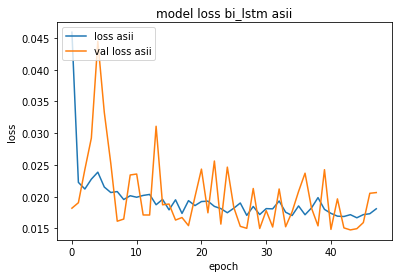

In [63]:
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['val_loss'], label = 'val loss asii')
plt.title('model loss bi_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_bidirection', dpi=3600)

## ICBP

In [64]:
# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_icbp = [8,'relu',1,1,0.01,16,200]
model_bidirectional_icbp,history_icbp_model_bidirectional,  = train_bidirectional_lstm(X_train_icbp,y_train_icbp,cfg_icbp)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 6s 11ms/step - loss: 0.1290 - mae: 0.1290 - val_loss: 0.0255 - val_mae: 0.0255
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0218 - mae: 0.0218 - val_loss: 0.0179 - val_mae: 0.0179
Epoch 3/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0154 - mae: 0.0154 - val_loss: 0.0116 - va

In [65]:
preds_icbp_bidirectional = model_icbp.predict(X_test_icbp)
matriks_evaluate(preds_icbp_bidirectional,y_test_icbp,'icbp')

Matriks score for icbp
mae score: 0.007997358211912574
r2 score 0.9981225345901428
mape score 0.031065277983877787
rmse score 0.012033815222868439


In [66]:
# Matriks score for icbp
pembulatan(0.008158403586629956
,4)
pembulatan(0.9980247438805004,4)
pembulatan(0.030377509121236643,4)
pembulatan(0.012536216195277372,4)

0.0082
0.998
0.0304
0.0125


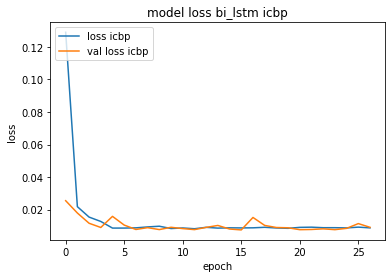

In [67]:
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['val_loss'], label = 'val loss icbp')
plt.title('model loss bi_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_bidirection', dpi=3600)

## JSMR

In [68]:
#get data and normalize data
df_jsmr = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr = reset_index_data(df_jsmr)
#data to supervised
jsmr_X, jsmr_y = split_sequence(df_jsmr, 1)
#split to train and test
X_train_jsmr, X_test_jsmr, y_train_jsmr, y_test_jsmr = train_test_split(jsmr_X, jsmr_y, test_size=0.33, random_state=42)

X_train_jsmr = reshape_data(X_train_jsmr,1)
X_test_jsmr = reshape_data(X_test_jsmr,1)


# neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs
cfg_jsmr = [8,'relu',1,1,0.01,16,200]
model_bidirectional_jsmr,history_jsmr_model_bidirectional,  = train_bidirectional_lstm(X_train_jsmr,y_train_jsmr,cfg_jsmr)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 16)               640       
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 4s 8ms/step - loss: 0.1212 - mae: 0.1212 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0214 - mae: 0.0214 - val_loss: 0.0229 - val_mae: 0.0229
Epoch 3/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0206 - mae: 0.0206 - val_loss: 0.0175 - val

In [69]:
preds_jsmr_bidirectional = model_jsmr.predict(X_test_jsmr)
matriks_evaluate(preds_jsmr_bidirectional,y_test_jsmr,'jsmr')

Matriks score for jsmr
mae score: 0.011882986257626781
r2 score 0.9939668858325574
mape score 0.029697933156437987
rmse score 0.016611244844292602


In [70]:
# Matriks score for icbp
pembulatan(0.012283945702079847
,4)
pembulatan(0.9935778068483416,4)
pembulatan(0.034951478851676564,4)
pembulatan(0.017214637390602226,4)

0.0123
0.9936
0.035
0.0172


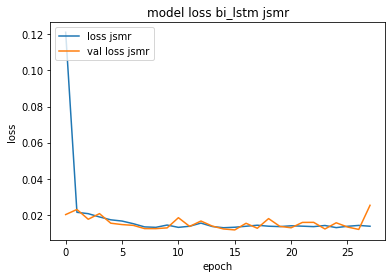

In [71]:
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss bi_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_bidirection', dpi=3600)

# CNN-LSTM

In [72]:
from keras.layers import Flatten 
from keras.layers import TimeDistributed 
from keras.layers.convolutional import Conv1D 
from keras.layers.convolutional import MaxPooling1D

In [73]:
def train_cnn_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(64,1,activation=activation), input_shape=(None,n_steps,n_features)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D()))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neuron, activation=activation))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_cnn_lstm.summary()
    history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_cnn_lstm, history_cnn_lstm

#time 41.8
    

In [74]:
def reshape_data_cnn(X,N_FEATURES, N_SEQ, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_STEPS,N_FEATURES)
    return X

## ANTM

In [75]:
#get data and normalize data
df_antm_cnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_cnn = reset_index_data(df_antm_cnn)
#data to supervised
antm_X_cnn, antm_y_cnn = split_sequence(df_antm_cnn, 2)
#split to train and test
X_train_antm_cnn, X_test_antm_cnn, y_train_antm_cnn, y_test_antm_cnn = train_test_split(antm_X_cnn, antm_y_cnn, test_size=0.33, random_state=44)

X_train_antm_cnn = reshape_data_cnn(X_train_antm_cnn,1,1,2)
X_test_antm_cnn = reshape_data_cnn(X_test_antm_cnn,1,1,2)

In [76]:
cfg_antm_cnn = [8,'relu',2,1,0.1,8,200]
model_cnn_antm,history_cnn_antm_model,  = train_cnn_lstm(X_train_antm_cnn,y_train_antm_cnn,cfg_antm_cnn)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_9 (LSTM)               (None, 8)                 2336      
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                     

In [77]:
preds_antm_cnn_lstm = model_cnn_antm.predict(X_test_antm_cnn)
matriks_evaluate(preds_antm_cnn_lstm,y_test_antm_cnn,'antm')

Matriks score for antm
mae score: 0.1410387598065004
r2 score -20429990008289.617
mape score 0.5935845594330547
rmse score 0.20205771833839717


In [78]:
# Matriks score for icbp
pembulatan(0.015414371122271182
,4)
pembulatan( 0.9890257070086954,4)
pembulatan(0.08284594660724198,4)
pembulatan(0.021565773748032896,4)

0.0154
0.989
0.0828
0.0216


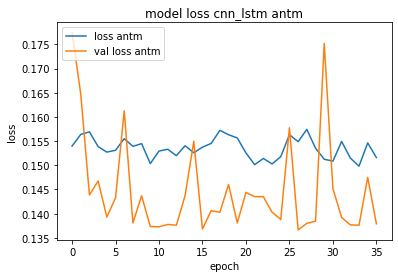

In [79]:
plt.plot(history_cnn_antm_model.history['loss'], label='loss antm')
plt.plot(history_cnn_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss cnn_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_cnn', dpi=3600)

## ASII

In [80]:
#get data and normalize data
df_asii_cnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_cnn = reset_index_data(df_asii_cnn)
#data to supervised
asii_X_cnn, asii_y_cnn = split_sequence(df_asii_cnn, 3)
#split to train and test
X_train_asii_cnn, X_test_asii_cnn, y_train_asii_cnn, y_test_asii_cnn = train_test_split(asii_X_cnn, asii_y_cnn, test_size=0.33, random_state=44)

X_train_asii_cnn = reshape_data_cnn(X_train_asii_cnn,1,1,3)
X_test_asii_cnn = reshape_data_cnn(X_test_asii_cnn,1,1,3)

In [81]:
cfg_asii_cnn = [32,'relu',3,1,0.1,8,150]
model_cnn_asii,history_cnn_asii_model,  = train_cnn_lstm(X_train_asii_cnn,y_train_asii_cnn,cfg_asii_cnn)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, None, 3, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_10 (LSTM)              (None, 32)                12416     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                     

In [82]:
preds_asii_cnn_lstm = model_cnn_asii.predict(X_test_asii_cnn)
matriks_evaluate(preds_asii_cnn_lstm,y_test_asii_cnn,'asii')

Matriks score for asii
mae score: 0.15362667053776016
r2 score -10706270637985.025
mape score 0.2531181876498277
rmse score 0.19502900846928675


In [83]:
# Matriks score for icbp
pembulatan(0.16039991534697168
,4)
pembulatan(0.0
,4)
pembulatan(0.25255010186300386,4)
pembulatan( 0.20769159327531062,4)

0.1604
0.0
0.2526
0.2077


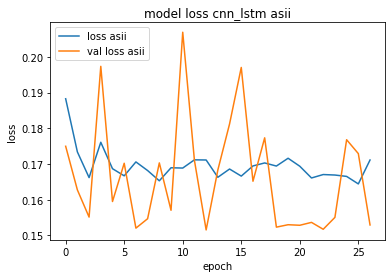

In [84]:
plt.plot(history_cnn_asii_model.history['loss'], label='loss asii')
plt.plot(history_cnn_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss cnn_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_cnn', dpi=3600)

## ICBP

In [85]:
#get data and normalize data
df_icbp_cnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_cnn = reset_index_data(df_icbp_cnn)
#data to supervised
icbp_X_cnn, icbp_y_cnn = split_sequence(df_icbp_cnn, 2)
#split to train and test
X_train_icbp_cnn, X_test_icbp_cnn, y_train_icbp_cnn, y_test_icbp_cnn = train_test_split(icbp_X_cnn, icbp_y_cnn, test_size=0.33, random_state=44)

X_train_icbp_cnn = reshape_data_cnn(X_train_icbp_cnn,1,1,2)
X_test_icbp_cnn = reshape_data_cnn(X_test_icbp_cnn,1,1,2)

In [86]:
cfg_icbp_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_icbp,history_cnn_icbp_model,  = train_cnn_lstm(X_train_icbp_cnn,y_train_icbp_cnn,cfg_icbp_cnn)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm_11 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                     

In [87]:
preds_icbp_cnn_lstm = model_cnn_icbp.predict(X_test_icbp_cnn)
matriks_evaluate(preds_icbp_cnn_lstm,y_test_icbp_cnn,'icbp')

Matriks score for icbp
mae score: 0.011964645760591485
r2 score 0.9964868614180905
mape score 0.2122993775323152
rmse score 0.01595550039358341


In [88]:
# Matriks score for icbp
pembulatan(0.009021557054612142
,4)
pembulatan( 0.9975961517896443
,4)
pembulatan(0.05735294469845109,4)
pembulatan(0.01385724526319,4)

0.009
0.9976
0.0574
0.0139


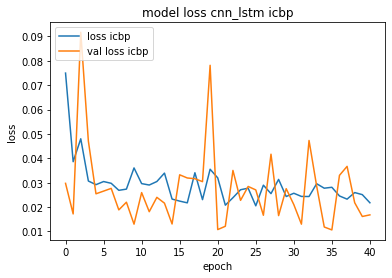

In [89]:
plt.plot(history_cnn_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_cnn_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss cnn_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_cnn', dpi=3600)

## JSMR

In [90]:
#get data and normalize data
df_jsmr_cnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_cnn = reset_index_data(df_jsmr_cnn)
#data to supervised
jsmr_X_cnn, jsmr_y_cnn = split_sequence(df_jsmr_cnn, 4)
#split to train and test
X_train_jsmr_cnn, X_test_jsmr_cnn, y_train_jsmr_cnn, y_test_jsmr_cnn = train_test_split(jsmr_X_cnn, jsmr_y_cnn, test_size=0.33, random_state=44)

X_train_jsmr_cnn = reshape_data_cnn(X_train_jsmr_cnn,1,2,2)
X_test_jsmr_cnn = reshape_data_cnn(X_test_jsmr_cnn,1,2,2)

In [91]:
cfg_jsmr_cnn = [8,'relu',2,1,0.1,16,200]
model_cnn_jsmr,history_cnn_jsmr_model,  = train_cnn_lstm(X_train_jsmr_cnn,y_train_jsmr_cnn,cfg_jsmr_cnn)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, None, 2, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, None, 1, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, None, 64)         0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 8)                 2336      
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                     

In [92]:
preds_jsmr_cnn_lstm = model_cnn_jsmr.predict(X_test_jsmr_cnn)
matriks_evaluate(preds_jsmr_cnn_lstm,y_test_jsmr_cnn,'jsmr')

Matriks score for jsmr
mae score: 0.015681303288536574
r2 score 0.9890593067161054
mape score 0.03877769577461792
rmse score 0.021555345824139153


In [93]:
# Matriks score for icbp
pembulatan(0.016145939354409146
,4)
pembulatan(0.9886551999427896
,4)
pembulatan( 0.04581825454627506,4)
pembulatan(0.02156588557280555,4)

0.0161
0.9887
0.0458
0.0216


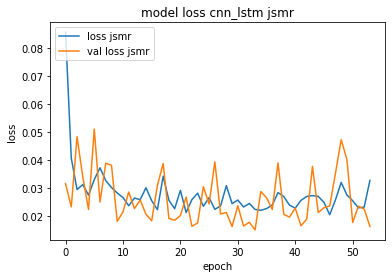

In [94]:
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_cnn_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss cnn_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_cnn', dpi=3600)

# CONVLSTM

In [95]:
def train_conv_lstm(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps,n_seq,n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_conv_lstm = Sequential()
    model_conv_lstm.add(ConvLSTM2D(neuron,(1,2),activation=activation, input_shape=(n_seq,1,n_steps,n_features)))
    model_conv_lstm.add(Flatten())
    model_conv_lstm.add(Dense(1))
    model_conv_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_conv_lstm.summary()
    history_conv_lstm = model_conv_lstm.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_conv_lstm, history_conv_lstm

#time 41.8
    

In [96]:
def reshape_data_conv(X,N_FEATURES, N_SEQ,N_ROWS, N_STEPS):
    X = X.reshape(X.shape[0],N_SEQ,N_ROWS,N_STEPS,N_FEATURES)
    return X

## ANTM

In [97]:
#get data and normalize data
df_antm_conv = normalize_data(data_close.antm,'antm')
#reset index
df_antm_conv = reset_index_data(df_antm_conv)
#data to supervised
antm_X_conv, antm_y_conv = split_sequence(df_antm_conv, 2)
#split to train and test
X_train_antm_conv, X_test_antm_conv, y_train_antm_conv, y_test_antm_conv = train_test_split(antm_X_conv, antm_y_conv, test_size=0.33, random_state=42)

X_train_antm_conv = reshape_data_conv(X_train_antm_conv,1,1,1,2)
X_test_antm_conv = reshape_data_conv(X_test_antm_conv,1,1,1,2)

In [98]:
cfg_antm_conv = [8,'relu',2,1,1,0.1,8,200]
model_conv_antm,history_conv_antm_model,  = train_conv_lstm(X_train_antm_conv,y_train_antm_conv,cfg_antm_conv)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 8)           608       
                                                                 
 flatten_4 (Flatten)         (None, 8)                 0         
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 4s 6ms/step - loss: 0.0376 - mae: 0.0376 - val_loss: 0.0900 - val_mae: 0.0900
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.0173 - val_mae: 0.0173
Epoch 3/200
210/210 [==============================] 

In [99]:
preds_antm_conv_lstm = model_conv_antm.predict(X_test_antm_conv)
matriks_evaluate(preds_antm_conv_lstm,y_test_antm_conv,'antm')

Matriks score for antm
mae score: 0.009643349400900865
r2 score 0.9940310506271461
mape score 0.0485629163736203
rmse score 0.01591248549012531


In [100]:
# Matriks score for icbp
pembulatan(0.00899146769793364
,4)
pembulatan(0.9945626336182707
,4)
pembulatan( 0.04416493169252824,4)
pembulatan(0.014825447398887685,4)

0.009
0.9946
0.0442
0.0148


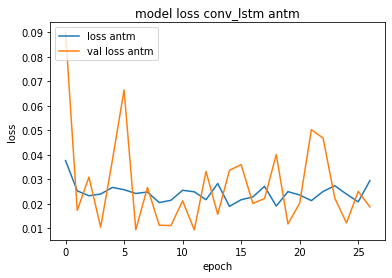

In [101]:
plt.plot(history_conv_antm_model.history['loss'], label='loss antm')
plt.plot(history_conv_antm_model.history['val_loss'], label = 'val loss antm')
plt.title('model loss conv_lstm antm')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_antm_conv', dpi=3600)

## ASII

In [102]:
#get data and normalize data
df_asii_conv = normalize_data(data_close.asii,'asii')
#reset index
df_asii_conv = reset_index_data(df_asii_conv)
#data to supervised
asii_X_conv, asii_y_conv = split_sequence(df_asii_conv, 3)
#split to train and test
X_train_asii_conv, X_test_asii_conv, y_train_asii_conv, y_test_asii_conv = train_test_split(asii_X_conv, asii_y_conv, test_size=0.33, random_state=42)

X_train_asii_conv = reshape_data_conv(X_train_asii_conv,1,1,1,3)
X_test_asii_conv = reshape_data_conv(X_test_asii_conv,1,1,1,3)

In [103]:
cfg_asii_conv = [32,'relu',3,1,1,0.1,8,150]
model_conv_asii,history_conv_asii_model,  = train_conv_lstm(X_train_asii_conv,y_train_asii_conv,cfg_asii_conv)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 2, 32)          8576      
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 4s 6ms/step - loss: 0.0608 - mae: 0.0608 - val_loss: 0.0824 - val_mae: 0.0824
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0467 - mae: 0.0467 - val_loss: 0.0404 - val_mae: 0.0404
Epoch 3/150
210/210 [============================

In [104]:
preds_asii_conv_lstm = model_conv_asii.predict(X_test_asii_conv)
matriks_evaluate(preds_asii_conv_lstm,y_test_asii_conv,'asii')

Matriks score for asii
mae score: 0.016828654208494314
r2 score 0.9846101437657186
mape score 0.04225764919762178
rmse score 0.024114879790995084


In [105]:
# Matriks score for icbp
pembulatan(0.016818273375650103
,4)
pembulatan(0.9857358941786828
,4)
pembulatan(0.04129176376671524,4)
pembulatan(0.023619429769432734,4)

0.0168
0.9857
0.0413
0.0236


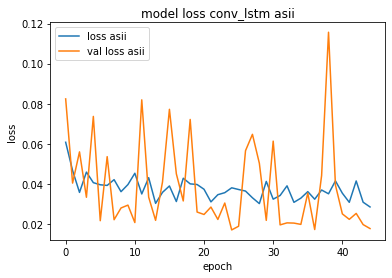

In [106]:
plt.plot(history_conv_asii_model.history['loss'], label='loss asii')
plt.plot(history_conv_asii_model.history['val_loss'], label = 'val loss asii')
plt.title('model loss conv_lstm asii')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_asii_conv', dpi=3600)

## ICBP

In [107]:
#get data and normalize data
df_icbp_conv = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_conv = reset_index_data(df_icbp_conv)
#data to supervised
icbp_X_conv, icbp_y_conv = split_sequence(df_icbp_conv, 2)
#split to train and test
X_train_icbp_conv, X_test_icbp_conv, y_train_icbp_conv, y_test_icbp_conv = train_test_split(icbp_X_conv, icbp_y_conv, test_size=0.33, random_state=42)

X_train_icbp_conv = reshape_data_conv(X_train_icbp_conv,1,1,1,2)
X_test_icbp_conv = reshape_data_conv(X_test_icbp_conv,1,1,1,2)

In [108]:
cfg_icbp_conv = [8,'relu',2,1,1,0.1,16,200]
model_conv_icbp,history_conv_icbp_model,  = train_conv_lstm(X_train_icbp_conv,y_train_icbp_conv,cfg_icbp_conv)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 1, 8)           608       
                                                                 
 flatten_6 (Flatten)         (None, 8)                 0         
                                                                 
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 617
Trainable params: 617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 4s 8ms/step - loss: 0.1459 - mae: 0.1459 - val_loss: 0.0760 - val_mae: 0.0760
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0398 - mae: 0.0398 - val_loss: 0.0226 - val_mae: 0.0226
Epoch 3/200
105/105 [==============================] 

In [109]:
preds_icbp_conv_lstm = model_conv_icbp.predict(X_test_icbp_conv)
matriks_evaluate(preds_icbp_conv_lstm,y_test_icbp_conv,'icbp')

Matriks score for icbp
mae score: 0.008744859838185738
r2 score 0.997806708640512
mape score 0.046034094913024466
rmse score 0.012932532242201412


In [110]:
# Matriks score for icbp
pembulatan(0.009322962515857982
,4)
pembulatan(0.997746948456813
,4)
pembulatan(0.04788248155294555,4)
pembulatan(0.013408763512437624,4)

0.0093
0.9977
0.0479
0.0134


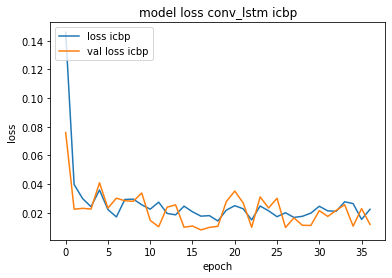

In [111]:
plt.plot(history_conv_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_conv_icbp_model.history['val_loss'], label = 'val loss icbp')
plt.title('model loss conv_lstm icbp')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_icbp_conv', dpi=3600)

## JSMR

In [112]:
#get data and normalize data
df_jsmr_conv = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_conv = reset_index_data(df_jsmr_conv)
#data to supervised
jsmr_X_conv, jsmr_y_conv = split_sequence(df_jsmr_conv, 4)
#split to train and test
X_train_jsmr_conv, X_test_jsmr_conv, y_train_jsmr_conv, y_test_jsmr_conv = train_test_split(jsmr_X_conv, jsmr_y_conv, test_size=0.33, random_state=42)

X_train_jsmr_conv = reshape_data_conv(X_train_jsmr_conv,1,1,1,4)
X_test_jsmr_conv = reshape_data_conv(X_test_jsmr_conv,1,1,1,4)

In [113]:
cfg_jsmr_conv = [8,'relu',4,1,1,0.1,16,200]
model_conv_jsmr,history_conv_jsmr_model  = train_conv_lstm(X_train_jsmr_conv,y_train_jsmr_conv,cfg_jsmr_conv)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 3, 8)           608       
                                                                 
 flatten_7 (Flatten)         (None, 24)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 25        
                                                                 
Total params: 633
Trainable params: 633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 4s 8ms/step - loss: 0.0563 - mae: 0.0563 - val_loss: 0.0394 - val_mae: 0.0394
Epoch 2/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0420 - mae: 0.0420 - val_loss: 0.0294 - val_mae: 0.0294
Epoch 3/200
105/105 [==============================] 

In [114]:
preds_jsmr_conv_lstm = model_conv_jsmr.predict(X_test_jsmr_conv)
matriks_evaluate(preds_jsmr_conv_lstm,y_test_jsmr_conv,'jsmr')

Matriks score for jsmr
mae score: 0.012344592858371946
r2 score 0.993183046166509
mape score 0.03836134077659935
rmse score 0.017419576776654448


In [115]:
# Matriks score for icbp
pembulatan(0.012202475640973126
,4)
pembulatan(0.9938728499355909
,4)
pembulatan(0.037885215374269934,4)
pembulatan(0.016706095457821767,4)

0.0122
0.9939
0.0379
0.0167


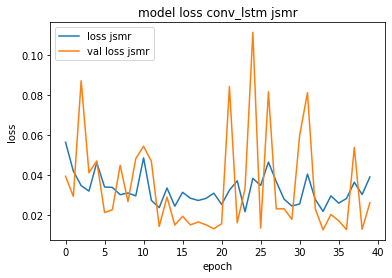

In [116]:
plt.plot(history_conv_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_conv_jsmr_model.history['val_loss'], label = 'val loss jsmr')
plt.title('model loss conv_lstm jsmr')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss_lstm_jsmr_conv', dpi=3600)

# RNN

In [117]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def train_rnn(X_train,y_train,config):
    
    #unpach config
    neuron, activation, n_steps, n_features,learning_rate, batch_size,epochs = config
    #define model 
    model_rnn = Sequential([
    SimpleRNN(neuron, activation=activation,input_shape=(n_steps, n_features)),
    Dense(1),
    ])
    model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error',
    metrics=['mae'],
    )
    early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
    )

    model_rnn.summary()
    history_model_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2,
          epochs=epochs,
          batch_size=batch_size,
          callbacks=[early_stopping],
          shuffle = True
    )

    return model_rnn, history_model_rnn

#time 41.8
    

## ANTM

In [118]:
#get data and normalize data
df_antm_rnn = normalize_data(data_close.antm,'antm')
#reset index
df_antm_rnn = reset_index_data(df_antm_rnn)
#data to supervised
antm_X_rnn, antm_y_rnn = split_sequence(df_antm_rnn, 2)
#split to train and test
X_train_antm_rnn, X_test_antm_rnn, y_train_antm_rnn, y_test_antm_rnn = train_test_split(antm_X_rnn, antm_y_rnn, test_size=0.33, random_state=42)

X_train_antm_rnn = reshape_data(X_train_antm_rnn,1)
X_test_antm_rnn = reshape_data(X_test_antm_rnn,1)


In [119]:
cfg_antm_rnn = [8,'relu',2,1,0.1,8,200]
model_antm_rnn,history_antm_model_rnn,  = train_rnn(X_train_antm_rnn,y_train_antm_rnn,cfg_antm_rnn)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 8)                 80        
                                                                 
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
210/210 [==============================] - 3s 7ms/step - loss: 0.0431 - mae: 0.0431 - val_loss: 0.0386 - val_mae: 0.0386
Epoch 2/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0283 - mae: 0.0283 - val_loss: 0.0146 - val_mae: 0.0146
Epoch 3/200
210/210 [==============================] - 1s 3ms/step - loss: 0.0290 - mae: 0.0290 - val_loss: 0.0508 - val_mae: 0.0508
Epoch 4/200
210/210 [==============================] -

In [120]:
preds_antm_rnn = model_antm_rnn.predict(X_test_antm_rnn)
matriks_evaluate(preds_antm_rnn,y_test_antm_rnn,'antm')

Matriks score for antm
mae score: 0.010741172328190532
r2 score 0.9918942103762897
mape score 0.060096347557924944
rmse score 0.018061080505563522


In [222]:
# Matriks score for antm
pembulatan(0.010741172328190532,2)
pembulatan(0.9918942103762897,2)
pembulatan(0.060096347557924944,2)
pembulatan(0.018061080505563522,2)

0.01
0.99
0.06
0.02


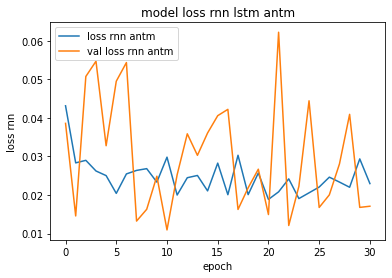

In [122]:
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.plot(history_antm_model_rnn.history['val_loss'], label = 'val loss rnn antm')
plt.title('model loss rnn lstm antm')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_antm', dpi=3600)

## ASII

In [123]:
#get data and normalize data
df_asii_rnn = normalize_data(data_close.asii,'asii')
#reset index
df_asii_rnn = reset_index_data(df_asii_rnn)
#data to supervised
asii_X_rnn, asii_y_rnn = split_sequence(df_asii_rnn, 3)
#split to train and test
X_train_asii_rnn, X_test_asii_rnn, y_train_asii_rnn, y_test_asii_rnn = train_test_split(asii_X_rnn, asii_y_rnn, test_size=0.33, random_state=42)

X_train_asii_rnn = reshape_data(X_train_asii_rnn,1)
X_test_asii_rnn = reshape_data(X_test_asii_rnn,1)


In [124]:
cfg_asii_rnn = [32,'relu',3,1,0.01,8,150]
model_asii_rnn,history_asii_model_rnn  = train_vanila_lstm(X_train_asii_rnn,y_train_asii_rnn,cfg_asii_rnn)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 32)                4352      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 4s 6ms/step - loss: 0.0482 - mae: 0.0482 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 2/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.0180 - val_mae: 0.0180
Epoch 3/150
210/210 [==============================] - 1s 4ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0313 - val_mae: 0.0313
Epoch 4/150
210/210 [===========================

In [125]:
preds_asii_rnn = model_asii_rnn.predict(X_test_asii_rnn)
matriks_evaluate(preds_asii_rnn,y_test_asii_rnn,'asii')

Matriks score for asii
mae score: 0.015914330474278645
r2 score 0.9885614488301483
mape score 0.03636492712057832
rmse score 0.021127646720336422


In [223]:
# Matriks score for antm
pembulatan(0.015914330474278645,2)
pembulatan(0.9885614488301483,2)
pembulatan(0.03636492712057832,2)
pembulatan(0.021127646720336422,2)

0.02
0.99
0.04
0.02


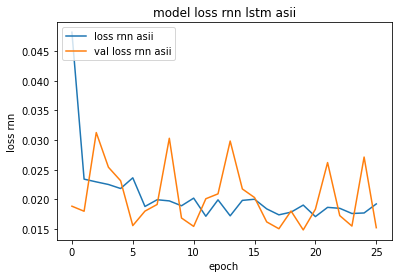

In [127]:
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.plot(history_asii_model_rnn.history['val_loss'], label = 'val loss rnn asii')
plt.title('model loss rnn lstm asii')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_asii', dpi=3600)

## ICBP

In [128]:
#get data and normalize data
df_icbp_rnn = normalize_data(data_close.icbp,'icbp')
#reset index
df_icbp_rnn = reset_index_data(df_icbp_rnn)
#data to supervised
icbp_X_rnn, icbp_y_rnn = split_sequence(df_icbp_rnn, 1)
#split to train and test
X_train_icbp_rnn, X_test_icbp_rnn, y_train_icbp_rnn, y_test_icbp_rnn = train_test_split(icbp_X_rnn, icbp_y_rnn, test_size=0.33, random_state=42)

X_train_icbp_rnn = reshape_data(X_train_icbp_rnn,1)
X_test_icbp_rnn = reshape_data(X_test_icbp_rnn,1)


In [129]:
cfg_icbp_rnn = [8,'relu',1,1,0.01,16,200]
model_icbp_rnn,history_icbp_model_rnn  = train_vanila_lstm(X_train_icbp_rnn,y_train_icbp_rnn,cfg_icbp_rnn)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 8)                 320       
                                                                 
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 4ms/step - loss: 0.1900 - mae: 0.1900 - val_loss: 0.0445 - val_mae: 0.0445
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0251 - mae: 0.0251 - val_loss: 0.0192 - val_mae: 0.0192
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0186 - val_mae: 0.0186
Epoch 4/200
105/105 [==============================]

In [130]:
preds_icbp_rnn = model_icbp_rnn.predict(X_test_icbp_rnn)
matriks_evaluate(preds_icbp_rnn,y_test_icbp_rnn,'icbp')

Matriks score for icbp
mae score: 0.00711330182514861
r2 score 0.9983892788539427
mape score 0.02951979782237006
rmse score 0.011162714381708384


In [224]:
# Matriks score for antm
pembulatan(0.00711330182514861,2)
pembulatan(0.9983892788539427,2)
pembulatan(0.02951979782237006,2)
pembulatan(0.011162714381708384,2)

0.01
1.0
0.03
0.01


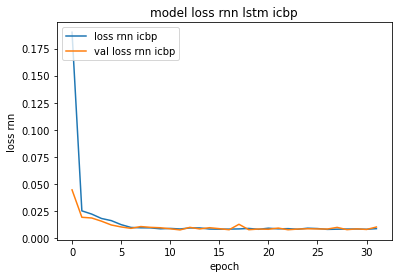

In [132]:
plt.plot(history_icbp_model_rnn.history['loss'], label='loss rnn icbp')
plt.plot(history_icbp_model_rnn.history['val_loss'], label = 'val loss rnn icbp')
plt.title('model loss rnn lstm icbp')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_icbp', dpi=3600)

## JSMR

In [133]:
#get data and normalize data
df_jsmr_rnn = normalize_data(data_close.jsmr,'jsmr')
#reset index
df_jsmr_rnn = reset_index_data(df_jsmr_rnn)
#data to supervised
jsmr_X_rnn, jsmr_y_rnn = split_sequence(df_jsmr_rnn, 1)
#split to train and test
X_train_jsmr_rnn, X_test_jsmr_rnn, y_train_jsmr_rnn, y_test_jsmr_rnn = train_test_split(jsmr_X_rnn, jsmr_y_rnn, test_size=0.33, random_state=42)

X_train_jsmr_rnn = reshape_data(X_train_jsmr_rnn,1)
X_test_jsmr_rnn = reshape_data(X_test_jsmr_rnn,1)


In [134]:
cfg_jsmr_rnn = [8,'relu',1,1,0.01,16,200]
model_jsmr_rnn,history_jsmr_model_rnn  = train_vanila_lstm(X_train_jsmr_rnn,y_train_jsmr_rnn,cfg_jsmr_rnn)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 8)                 320       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
105/105 [==============================] - 2s 6ms/step - loss: 0.2259 - mae: 0.2259 - val_loss: 0.0980 - val_mae: 0.0980
Epoch 2/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0527 - mae: 0.0527 - val_loss: 0.0204 - val_mae: 0.0204
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.0212 - mae: 0.0212 - val_loss: 0.0189 - val_mae: 0.0189
Epoch 4/200
105/105 [==============================]

In [135]:
preds_jsmr_rnn = model_jsmr_rnn.predict(X_test_jsmr_rnn)
matriks_evaluate(preds_jsmr_rnn,y_test_jsmr_rnn,'jsmr')

Matriks score for jsmr
mae score: 0.012338966520174058
r2 score 0.9937091635343116
mape score 0.03653204377319999
rmse score 0.01700316253230632


In [225]:
# Matriks score for antm
pembulatan(0.012338966520174058,2)
pembulatan(0.9937091635343116,2)
pembulatan(0.03653204377319999,2)
pembulatan(0.01700316253230632,2)

0.01
0.99
0.04
0.02


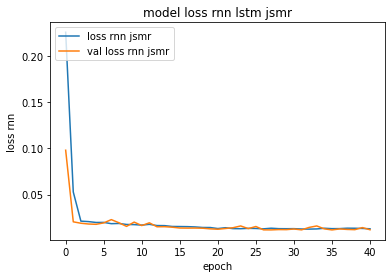

In [137]:
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.plot(history_jsmr_model_rnn.history['val_loss'], label = 'val loss rnn jsmr')
plt.title('model loss rnn lstm jsmr')
plt.ylabel('loss rnn')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('loss rnn_jsmr', dpi=3600)

# Komparasi berdasarkan Data saham

## ANTM

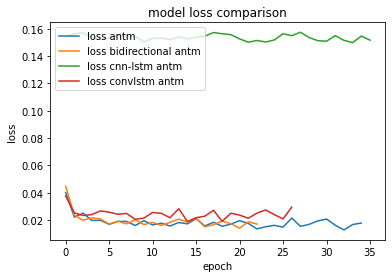

In [186]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=1200)

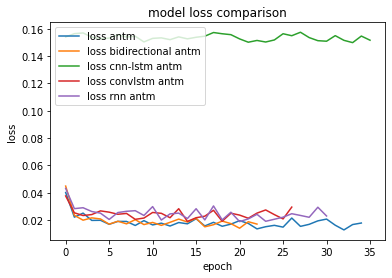

In [138]:
plt.plot(history_antm_model.history['loss'], label='loss antm')
plt.plot(history_antm_model_bidirectional.history['loss'], label='loss bidirectional antm')
plt.plot(history_cnn_antm_model.history['loss'], label='loss cnn-lstm antm')
plt.plot(history_conv_antm_model.history['loss'], label='loss convlstm antm')
plt.plot(history_antm_model_rnn.history['loss'], label='loss rnn antm')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_antm', dpi=3600)

## ASII

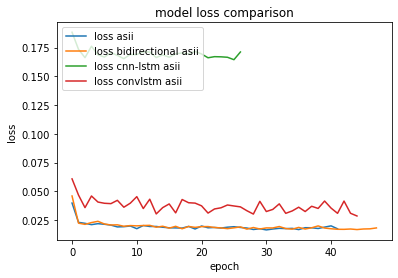

In [187]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=1200)

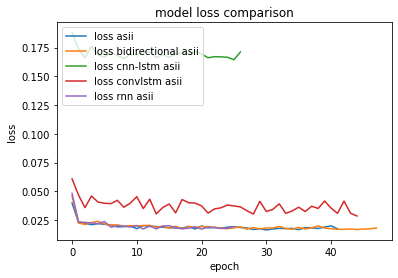

In [139]:
plt.plot(history_asii_model.history['loss'], label='loss asii')
plt.plot(history_asii_model_bidirectional.history['loss'], label='loss bidirectional asii')
plt.plot(history_cnn_asii_model.history['loss'], label='loss cnn-lstm asii')
plt.plot(history_conv_asii_model.history['loss'], label='loss convlstm asii')
plt.plot(history_asii_model_rnn.history['loss'], label='loss rnn asii')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_asii', dpi=3600)

## ICBP

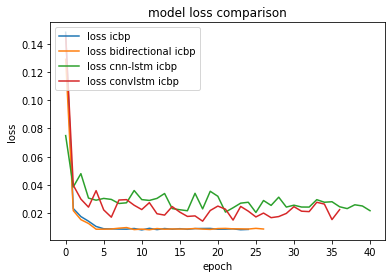

In [188]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

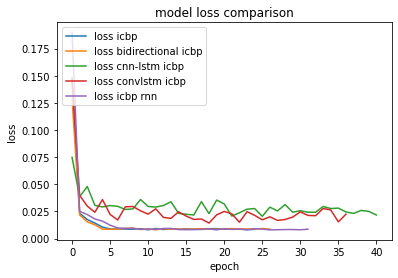

In [185]:
plt.plot(history_icbp_model.history['loss'], label='loss icbp')
plt.plot(history_icbp_model_bidirectional.history['loss'], label='loss bidirectional icbp')
plt.plot(history_cnn_icbp_model.history['loss'], label='loss cnn-lstm icbp')
plt.plot(history_conv_icbp_model.history['loss'], label='loss convlstm icbp')
plt.plot(history_icbp_model_rnn.history['loss'], label='loss icbp rnn')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_icbp', dpi=1200)

## JSMR

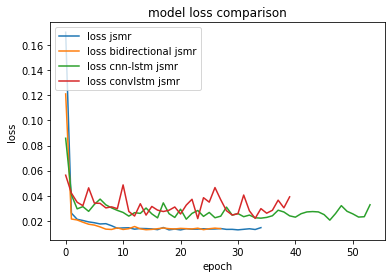

In [189]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=1200)

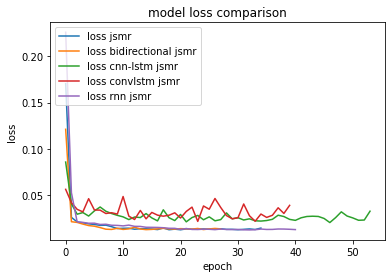

In [141]:
plt.plot(history_jsmr_model.history['loss'], label='loss jsmr')
plt.plot(history_jsmr_model_bidirectional.history['loss'], label='loss bidirectional jsmr')
plt.plot(history_cnn_jsmr_model.history['loss'], label='loss cnn-lstm jsmr')
plt.plot(history_conv_jsmr_model.history['loss'], label='loss convlstm jsmr')
plt.plot(history_jsmr_model_rnn.history['loss'], label='loss rnn jsmr')
plt.title('model loss comparison')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.savefig('lstm&rnn_loss_model_comparison_jsmr', dpi=3600)

# KOMPARASI METRIKS EVALUASI Berdasarkan saham

In [142]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.savefig(title, dpi=1200)
    plt.show()

## ANTM

In [210]:
mae_antm_model = {'model\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_model = {'model\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_model = {'model\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_model = {'model\nlstm\nantm':r2_score(preds_antm, y_test_antm),'model\nbidirectional\nlstm':r2_score(preds_antm_bidirectional, y_test_antm),'model\ncnn\nlstm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'model\nconvlstm':r2_score(preds_antm_conv_lstm, y_test_antm_conv),'model\nrnn':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [211]:
print("sorted mae")
mae_antm_sorted = dict(sorted(mae_antm_model.items(),key=lambda item: item[1]))
print(mae_antm_sorted)
print("sorted rmse")
rmse_antm_sorted = dict(sorted(rmse_antm_model.items(),key=lambda item: item[1]))
print(rmse_antm_sorted)
print("sorted mape")
mape_antm_sorted = dict(sorted(mape_antm_model.items(),key=lambda item: item[1]))
print(mape_antm_sorted)
print("sorted r2")
r2_antm_sorted = dict(sorted(r2_antm_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_antm_sorted)

sorted mae
{'model\nlstm\nantm': 0.008427343064168029, 'model\nconvlstm': 0.009643349400900865, 'model\nbidirectional\nlstm': 0.010488952498763216, 'model\nrnn': 0.010741172328190532, 'model\ncnn\nlstm': 0.1410387598065004}
sorted rmse
{'model\nlstm\nantm': 0.014365594326758126, 'model\nconvlstm': 0.01591248549012531, 'model\nbidirectional\nlstm': 0.01594476119329387, 'model\nrnn': 0.018061080505563522, 'model\ncnn\nlstm': 0.20205771833839717}
sorted mape
{'model\nlstm\nantm': 0.03923833907975796, 'model\nconvlstm': 0.0485629163736203, 'model\nbidirectional\nlstm': 0.05216139668163591, 'model\nrnn': 0.060096347557924944, 'model\ncnn\nlstm': 0.5935845594330547}
sorted r2
{'model\nlstm\nantm': 0.9949248850014537, 'model\nbidirectional\nlstm': 0.9940892733454582, 'model\nconvlstm': 0.9940310506271461, 'model\nrnn': 0.9918942103762897, 'model\ncnn\nlstm': -20429990008289.617}


In [145]:
sorted mae
{'model_lstm_antm': 0.008427343064168029, 'model_convlstm': 0.009643349400900865, 'model_bidirectional_lstm': 0.010488952498763216, 'model_rnn': 0.010741172328190532, 'model_cnn_lstm': 0.1410387598065004}
sorted rmse
{'model_lstm_antm': 0.014365594326758126, 'model_convlstm': 0.01591248549012531, 'model_bidirectional_lstm': 0.01594476119329387, 'model_rnn': 0.018061080505563522, 'model_cnn_lstm': 0.20205771833839717}
sorted mape
{'model_lstm_antm': 0.03923833907975796, 'model_convlstm': 0.0485629163736203, 'model_bidirectional_lstm': 0.05216139668163591, 'model_rnn': 0.060096347557924944, 'model_cnn_lstm': 0.5935845594330547}
sorted r2
{'model_lstm_antm': 0.9949248850014537, 'model_bidirectional_lstm': 0.9940892733454582, 'model_convlstm': 0.9940310506271461, 'model_rnn': 0.9918942103762897, 'model_cnn_lstm': -20429990008289.617}

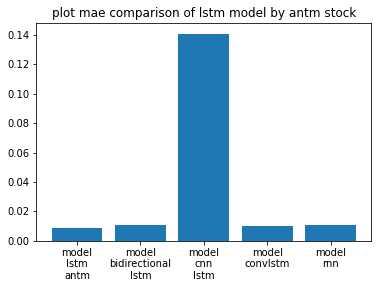

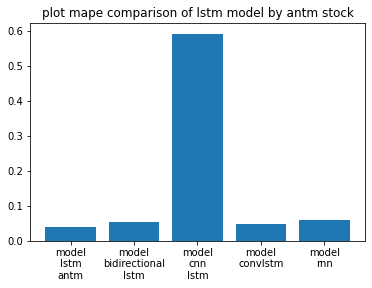

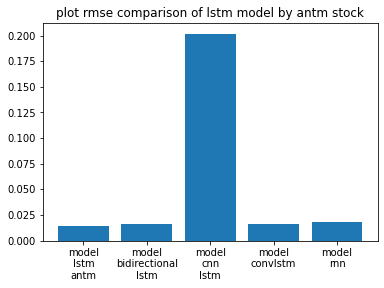

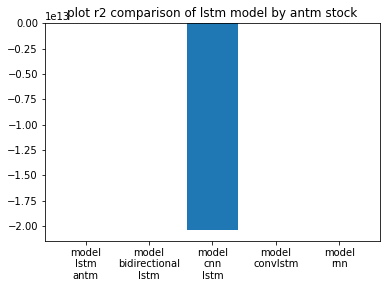

In [194]:
plot_metriks(mae_antm_model,"plot mae comparison of lstm model by antm stock")
plot_metriks(mape_antm_model,"plot mape comparison of lstm model by antm stock")
plot_metriks(rmse_antm_model,"plot rmse comparison of lstm model by antm stock")
plot_metriks(r2_antm_model,"plot r2 comparison of lstm model by antm stock")

## ASII

In [212]:
mae_asii_model = {'model\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_model = {'model\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_model = {'model\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_model = {'model\nlstm\nasii':r2_score(preds_asii, y_test_asii),'model\nbidirectional\nlstm':r2_score(preds_asii_bidirectional, y_test_asii),'model\ncnn\nlstm':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'model\nconvlstm':r2_score(preds_asii_conv_lstm, y_test_asii_conv),'model\nrnn':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [209]:
print("sorted mae")
mae_asii_sorted = dict(sorted(mae_asii_model.items(),key=lambda item: item[1]))
print(mae_asii_sorted)
print("sorted rmse")
rmse_asii_sorted = dict(sorted(rmse_asii_model.items(),key=lambda item: item[1]))
print(rmse_asii_sorted)
print("sorted mape")
mape_asii_sorted = dict(sorted(mape_asii_model.items(),key=lambda item: item[1]))
print(mape_asii_sorted)
print("sorted r2")
r2_asii_sorted = dict(sorted(r2_asii_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_asii_sorted)

sorted mae
{'model\nlstm\nasii': 0.015152538495704002, 'model\nbidirectional\nlstm': 0.015152538495704002, 'model\nrnn': 0.015914330474278645, 'model\nconvlstm': 0.016828654208494314, 'model\ncnn\nlstm': 0.15362667053776016}
sorted rmse
{'model\nlstm\nasii': 0.019901445064021188, 'model\nbidirectional\nlstm': 0.019901445064021188, 'model\nrnn': 0.021127646720336422, 'model\nconvlstm': 0.024114879790995084, 'model\ncnn\nlstm': 0.19502900846928675}
sorted mape
{'model\nlstm\nasii': 0.03352378584491088, 'model\nbidirectional\nlstm': 0.03352378584491088, 'model\nrnn': 0.03636492712057832, 'model\nconvlstm': 0.04225764919762178, 'model\ncnn\nlstm': 0.2531181876498277}
sorted r2
{'model\nlstm\nasii': 0.9899739556162052, 'model\nbidirectional\nlstm': 0.9899739556162052, 'model\nrnn': 0.9885614488301483, 'model\nconvlstm': 0.9846101437657186, 'model\ncnn\nlstm': -10706270637985.025}


In [148]:
sorted mae
{'model_lstm_asii': 0.015152538495704002, 'model_bidirectional_lstm': 0.015152538495704002, 'model_rnn': 0.015914330474278645, 'model_convlstm': 0.016828654208494314, 'model_cnn_lstm': 0.15362667053776016}
sorted rmse
{'model_lstm_asii': 0.019901445064021188, 'model_bidirectional_lstm': 0.019901445064021188, 'model_rnn': 0.021127646720336422, 'model_convlstm': 0.024114879790995084, 'model_cnn_lstm': 0.19502900846928675}
sorted mape
{'model_lstm_asii': 0.03352378584491088, 'model_bidirectional_lstm': 0.03352378584491088, 'model_rnn': 0.03636492712057832, 'model_convlstm': 0.04225764919762178, 'model_cnn_lstm': 0.2531181876498277}
sorted r2
{'model_lstm_asii': 0.9899739556162052, 'model_bidirectional_lstm': 0.9899739556162052, 'model_rnn': 0.9885614488301483, 'model_convlstm': 0.9846101437657186, 'model_cnn_lstm': -10706270637985.025}

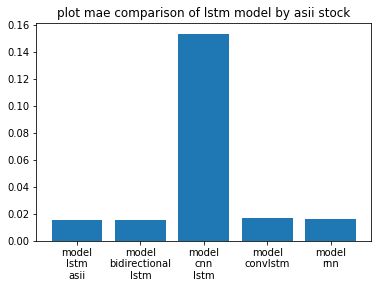

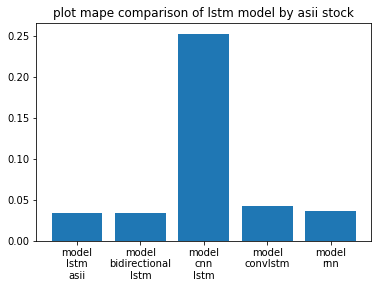

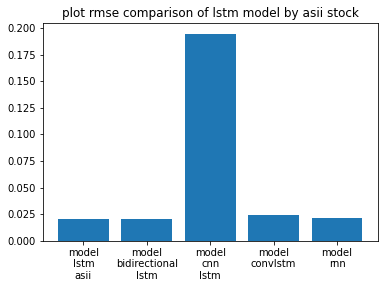

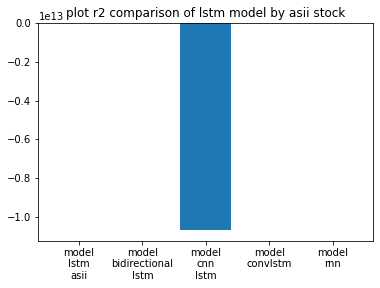

In [197]:
plot_metriks(mae_asii_model,"plot mae comparison of lstm model by asii stock")
plot_metriks(mape_asii_model,"plot mape comparison of lstm model by asii stock")
plot_metriks(rmse_asii_model,"plot rmse comparison of lstm model by asii stock")
plot_metriks(r2_asii_model,"plot r2 comparison of lstm model by asii stock")

## ICBP

In [213]:
mae_icbp_model = {'model\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_model = {'model\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_model = {'model\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_model = {'model\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'model\nbidirectional\nlstm':r2_score(preds_icbp_bidirectional, y_test_icbp),'model\ncnn\nlstm':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'model\nconvlstm':r2_score(preds_icbp_conv_lstm, y_test_icbp_conv),'model\nrnn':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [214]:
print("sorted mae")
mae_icbp_sorted = dict(sorted(mae_icbp_model.items(),key=lambda item: item[1]))
print(mae_icbp_sorted)
print("sorted rmse")
rmse_icbp_sorted = dict(sorted(rmse_icbp_model.items(),key=lambda item: item[1]))
print(rmse_icbp_sorted)
print("sorted mape")
mape_icbp_sorted = dict(sorted(mape_icbp_model.items(),key=lambda item: item[1]))
print(mape_icbp_sorted)
print("sorted r2")
r2_icbp_sorted = dict(sorted(r2_icbp_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_icbp_sorted)

sorted mae
{'model\nrnn': 0.00711330182514861, 'model\nlstm\nicbp': 0.007997358211912574, 'model\nbidirectional\nlstm': 0.007997358211912574, 'model\nconvlstm': 0.008744859838185738, 'model\ncnn\nlstm': 0.011964645760591485}
sorted rmse
{'model\nrnn': 0.011162714381708384, 'model\nlstm\nicbp': 0.012033815222868439, 'model\nbidirectional\nlstm': 0.012033815222868439, 'model\nconvlstm': 0.012932532242201412, 'model\ncnn\nlstm': 0.01595550039358341}
sorted mape
{'model\nrnn': 0.02951979782237006, 'model\nlstm\nicbp': 0.031065277983877787, 'model\nbidirectional\nlstm': 0.031065277983877787, 'model\nconvlstm': 0.046034094913024466, 'model\ncnn\nlstm': 0.2122993775323152}
sorted r2
{'model\nrnn': 0.9983892788539427, 'model\nlstm\nicbp': 0.9981225345901428, 'model\nbidirectional\nlstm': 0.9981225345901428, 'model\nconvlstm': 0.997806708640512, 'model\ncnn\nlstm': 0.9964868614180905}


In [151]:
sorted mae
{'model_rnn': 0.00711330182514861, 'model_lstm_icbp': 0.007997358211912574, 'model_bidirectional_lstm': 0.007997358211912574, 'model_convlstm': 0.008744859838185738, 'model_cnn_lstm': 0.011964645760591485}
sorted rmse
{'model_rnn': 0.011162714381708384, 'model_lstm_icbp': 0.012033815222868439, 'model_bidirectional_lstm': 0.012033815222868439, 'model_convlstm': 0.012932532242201412, 'model_cnn_lstm': 0.01595550039358341}
sorted mape
{'model_rnn': 0.02951979782237006, 'model_lstm_icbp': 0.031065277983877787, 'model_bidirectional_lstm': 0.031065277983877787, 'model_convlstm': 0.046034094913024466, 'model_cnn_lstm': 0.2122993775323152}
sorted r2
{'model_rnn': 0.9983892788539427, 'model_lstm_icbp': 0.9981225345901428, 'model_bidirectional_lstm': 0.9981225345901428, 'model_convlstm': 0.997806708640512, 'model_cnn_lstm': 0.9964868614180905}

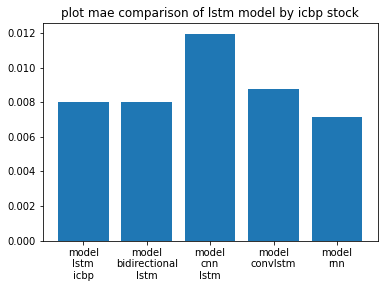

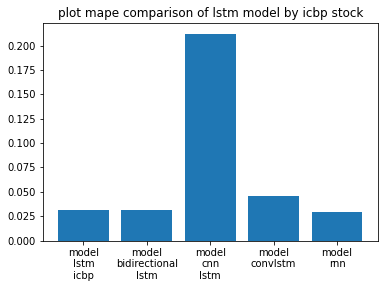

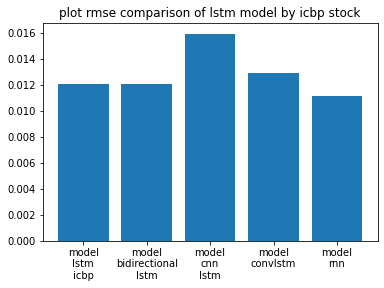

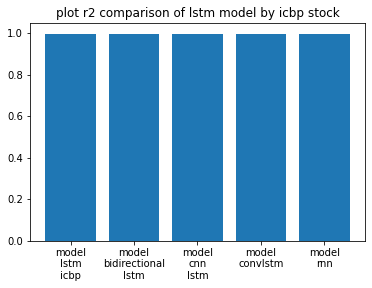

In [215]:
plot_metriks(mae_icbp_model,"plot mae comparison of lstm model by icbp stock")
plot_metriks(mape_icbp_model,"plot mape comparison of lstm model by icbp stock")
plot_metriks(rmse_icbp_model,"plot rmse comparison of lstm model by icbp stock")
plot_metriks(r2_icbp_model,"plot r2 comparison of lstm model by icbp stock")

## JSMR

In [216]:
mae_jsmr_model = {'model\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_model = {'model\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_model = {'model\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'model\nbidirectional\nlstm':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'model\ncnn\nlstm':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'model\nconvlstm':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'model\nrnn':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_model = {'model\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'model\nbidirectional\nlstm':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'model\ncnn\nlstm':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'model\nconvlstm':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'model\nrnn':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [217]:
print("sorted mae")
mae_jsmr_sorted = dict(sorted(mae_jsmr_model.items(),key=lambda item: item[1]))
print(mae_jsmr_sorted)
print("sorted rmse")
rmse_jsmr_sorted = dict(sorted(rmse_jsmr_model.items(),key=lambda item: item[1]))
print(rmse_jsmr_sorted)
print("sorted mape")
mape_jsmr_sorted = dict(sorted(mape_jsmr_model.items(),key=lambda item: item[1]))
print(mape_jsmr_sorted)
print("sorted r2")
r2_jsmr_sorted = dict(sorted(r2_jsmr_model.items(),key=lambda item: item[1] ,reverse=True))
print(r2_jsmr_sorted)

sorted mae
{'model\nlstm\njsmr': 0.011882986257626781, 'model\nbidirectional\nlstm': 0.011882986257626781, 'model\nrnn': 0.012338966520174058, 'model\nconvlstm': 0.012344592858371946, 'model\ncnn\nlstm': 0.015681303288536574}
sorted rmse
{'model\nlstm\njsmr': 0.016611244844292602, 'model\nbidirectional\nlstm': 0.016611244844292602, 'model\nrnn': 0.01700316253230632, 'model\nconvlstm': 0.017419576776654448, 'model\ncnn\nlstm': 0.021555345824139153}
sorted mape
{'model\nlstm\njsmr': 0.029697933156437987, 'model\nbidirectional\nlstm': 0.029697933156437987, 'model\nrnn': 0.03653204377319999, 'model\nconvlstm': 0.03836134077659935, 'model\ncnn\nlstm': 0.03877769577461792}
sorted r2
{'model\nlstm\njsmr': 0.9939668858325574, 'model\nbidirectional\nlstm': 0.9939668858325574, 'model\nrnn': 0.9937091635343116, 'model\nconvlstm': 0.993183046166509, 'model\ncnn\nlstm': 0.9890593067161054}


In [155]:
sorted mae
{'model_lstm_jsmr': 0.011882986257626781, 'model_bidirectional_lstm': 0.011882986257626781, 'model_rnn': 0.012338966520174058, 'model_convlstm': 0.012344592858371946, 'model_cnn_lstm': 0.015681303288536574}
sorted rmse
{'model_lstm_jsmr': 0.016611244844292602, 'model_bidirectional_lstm': 0.016611244844292602, 'model_rnn': 0.01700316253230632, 'model_convlstm': 0.017419576776654448, 'model_cnn_lstm': 0.021555345824139153}
sorted mape
{'model_lstm_jsmr': 0.029697933156437987, 'model_bidirectional_lstm': 0.029697933156437987, 'model_rnn': 0.03653204377319999, 'model_convlstm': 0.03836134077659935, 'model_cnn_lstm': 0.03877769577461792}
sorted r2
{'model_lstm_jsmr': 0.9939668858325574, 'model_bidirectional_lstm': 0.9939668858325574, 'model_rnn': 0.9937091635343116, 'model_convlstm': 0.993183046166509, 'model_cnn_lstm': 0.9890593067161054}

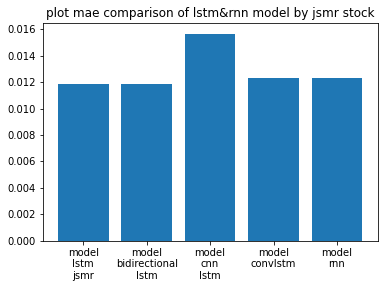

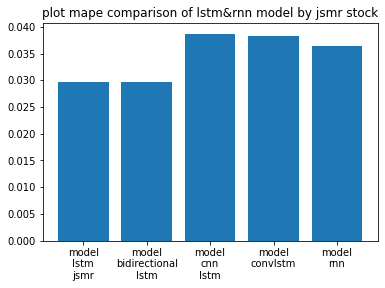

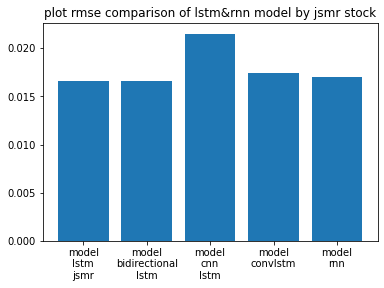

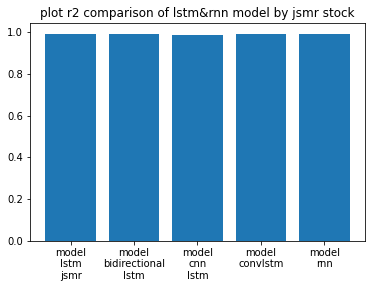

In [226]:
plot_metriks(mae_jsmr_model,"plot mae comparison of lstm&rnn model by jsmr stock")
plot_metriks(mape_jsmr_model,"plot mape comparison of lstm&rnn model by jsmr stock")
plot_metriks(rmse_jsmr_model,"plot rmse comparison of lstm&rnn model by jsmr stock")
plot_metriks(r2_jsmr_model,"plot r2 comparison of lstm&rnn model by jsmr stock")

# PLOT METRIKS EVALUASI

In [156]:
def plot_metriks(data,title):
    names = list(data.keys())
    values = list(data.values())
    plt.title(title)
    plt.bar(range(len(data)), values, tick_label=names)
    plt.show()

#### ANTM

In [157]:
mae_antm_plot = {'mae\nlstm\nantm':mean_absolute_error(preds_antm, y_test_antm),'mae\nbidirectional\nlstm\nantm':mean_absolute_error(preds_antm_bidirectional, y_test_antm),'mae\ncnn\nlstm\nantm':mean_absolute_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mae\nconvlstm\nantm':mean_absolute_error(preds_antm_conv_lstm, y_test_antm_conv),'mae\nrnn\natnm':mean_absolute_error(preds_antm_rnn, y_test_antm_rnn)}

mape_antm_plot = {'mape\nlstm\nantm':mean_absolute_percentage_error(preds_antm, y_test_antm),'mape\nbidirectional\nlstm\nantm':mean_absolute_percentage_error(preds_antm_bidirectional, y_test_antm),'mape\ncnn\nlstm\nantm':mean_absolute_percentage_error(preds_antm_cnn_lstm, y_test_antm_cnn),'mape\nconvlstm\nantm':mean_absolute_percentage_error(preds_antm_conv_lstm, y_test_antm),'mape\nrnn\nantm':mean_absolute_percentage_error(preds_antm_rnn, y_test_antm_rnn)}

rmse_antm_plot = {'rmse\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm, y_test_antm)),'rmse\nbidirectional\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_bidirectional, y_test_antm)),'rmse\ncnn\nlstm\nantm':np.sqrt(mean_squared_error(preds_antm_cnn_lstm, y_test_antm_cnn)),'convlstm\nantm':np.sqrt(mean_squared_error(preds_antm_conv_lstm, y_test_antm)),'rmse\nrnn\nantm':np.sqrt(mean_squared_error(preds_antm_rnn, y_test_antm_rnn))}

r2_antm_plot = {'r2\nlstm\nantm':r2_score(preds_antm, y_test_antm),'r2\nbidirectional\nlstm\nantm':r2_score(preds_antm_bidirectional, y_test_antm),'r2\ncnn\nlstm\nantm':r2_score(preds_antm_cnn_lstm, y_test_antm_cnn),'r2\nconvlstm\nantm':r2_score(preds_antm_conv_lstm, y_test_antm),'r2\nrnn\nantm':r2_score(preds_antm_rnn, y_test_antm_rnn)} 


In [158]:
mae_antm = 'Antm Mae'
mape_antm = 'Antm Mape'
rmse_antm = 'Antm Rmse'
r2_antm = 'Antm R2'

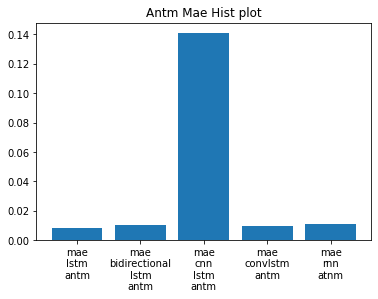

In [159]:
plot_metriks(mae_antm_plot,mae_antm + " Hist plot")

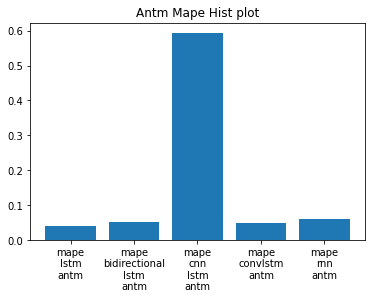

In [160]:
plot_metriks(mape_antm_plot,mape_antm + " Hist plot")

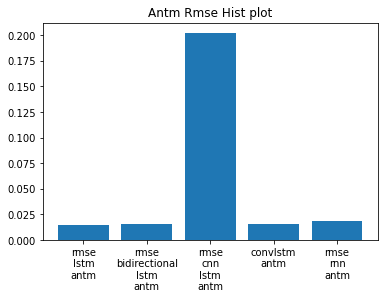

In [161]:
plot_metriks(rmse_antm_plot,rmse_antm + " Hist plot")

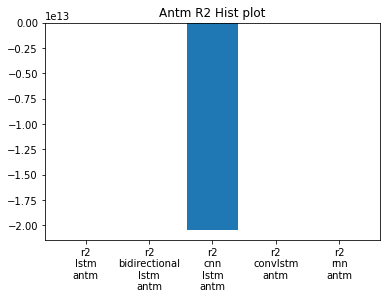

In [162]:
plot_metriks(r2_antm_plot,r2_antm +" Hist plot")

#### ASII

In [163]:
mae_asii_plot = {'mae\nlstm\nasii':mean_absolute_error(preds_asii, y_test_asii),'mae\nbidirectional\nlstm\nasii':mean_absolute_error(preds_asii_bidirectional, y_test_asii),'mae\ncnn\nlstm\nasii':mean_absolute_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mae\nconvlstm\nasii':mean_absolute_error(preds_asii_conv_lstm, y_test_asii_conv),'mae\nrnn\natnm':mean_absolute_error(preds_asii_rnn, y_test_asii_rnn)}

mape_asii_plot = {'mape\nlstm\nasii':mean_absolute_percentage_error(preds_asii, y_test_asii),'mape\nbidirectional\nlstm\nasii':mean_absolute_percentage_error(preds_asii_bidirectional, y_test_asii),'mape\ncnn\nlstm\nasii':mean_absolute_percentage_error(preds_asii_cnn_lstm, y_test_asii_cnn),'mape\nconvlstm\nasii':mean_absolute_percentage_error(preds_asii_conv_lstm, y_test_asii),'mape\nrnn\nasii':mean_absolute_percentage_error(preds_asii_rnn, y_test_asii_rnn)}

rmse_asii_plot = {'rmse\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii, y_test_asii)),'rmse\nbidirectional\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_bidirectional, y_test_asii)),'rmse\ncnn\nlstm\nasii':np.sqrt(mean_squared_error(preds_asii_cnn_lstm, y_test_asii_cnn)),'convlstm\nasii':np.sqrt(mean_squared_error(preds_asii_conv_lstm, y_test_asii)),'rmse\nrnn\nasii':np.sqrt(mean_squared_error(preds_asii_rnn, y_test_asii_rnn))}

r2_asii_plot = {'r2\nlstm\nasii':r2_score(preds_asii, y_test_asii),'r2\nbidirectional\nlstm\nasii':r2_score(preds_asii_bidirectional, y_test_asii),'r2\ncnn\nlstm\nasii':r2_score(preds_asii_cnn_lstm, y_test_asii_cnn),'r2\nconvlstm\nasii':r2_score(preds_asii_conv_lstm, y_test_asii),'r2\nrnn\nasii':r2_score(preds_asii_rnn, y_test_asii_rnn)} 


In [164]:
mae_asii = 'Asii Mae'
mape_asii = 'Asii Mape'
rmse_asii = 'Asii Rmse'
r2_asii = 'Asii R2'

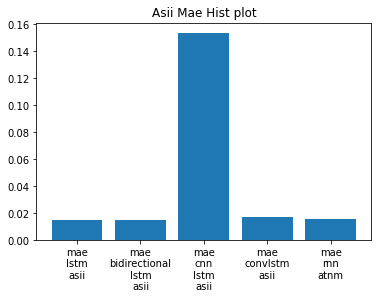

In [165]:
plot_metriks(mae_asii_plot,mae_asii + " Hist plot")

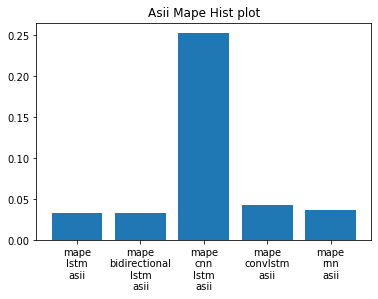

In [166]:
plot_metriks(mape_asii_plot,mape_asii + " Hist plot")

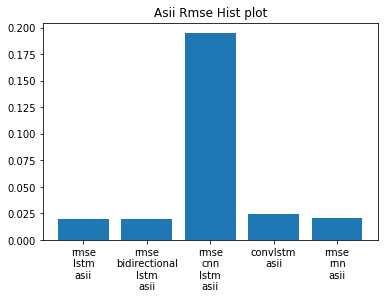

In [167]:
plot_metriks(rmse_asii_plot,rmse_asii + " Hist plot")

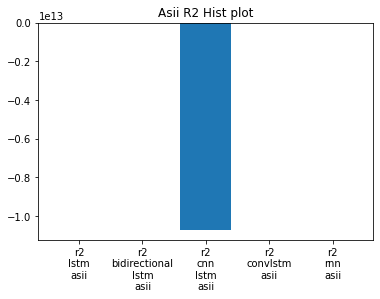

In [168]:
plot_metriks(r2_asii_plot,r2_asii +" Hist plot")

#### ICBP

In [169]:
mae_icbp_plot = {'mae\nlstm\nicbp':mean_absolute_error(preds_icbp, y_test_icbp),'mae\nbidirectional\nlstm\nicbp':mean_absolute_error(preds_icbp_bidirectional, y_test_icbp),'mae\ncnn\nlstm\nicbp':mean_absolute_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mae\nconvlstm\nicbp':mean_absolute_error(preds_icbp_conv_lstm, y_test_icbp_conv),'mae\nrnn\natnm':mean_absolute_error(preds_icbp_rnn, y_test_icbp_rnn)}

mape_icbp_plot = {'mape\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp, y_test_icbp),'mape\nbidirectional\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_bidirectional, y_test_icbp),'mape\ncnn\nlstm\nicbp':mean_absolute_percentage_error(preds_icbp_cnn_lstm, y_test_icbp_cnn),'mape\nconvlstm\nicbp':mean_absolute_percentage_error(preds_icbp_conv_lstm, y_test_icbp),'mape\nrnn\nicbp':mean_absolute_percentage_error(preds_icbp_rnn, y_test_icbp_rnn)}

rmse_icbp_plot = {'rmse\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp, y_test_icbp)),'rmse\nbidirectional\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_bidirectional, y_test_icbp)),'rmse\ncnn\nlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_cnn_lstm, y_test_icbp_cnn)),'convlstm\nicbp':np.sqrt(mean_squared_error(preds_icbp_conv_lstm, y_test_icbp)),'rmse\nrnn\nicbp':np.sqrt(mean_squared_error(preds_icbp_rnn, y_test_icbp_rnn))}

r2_icbp_plot = {'r2\nlstm\nicbp':r2_score(preds_icbp, y_test_icbp),'r2\nbidirectional\nlstm\nicbp':r2_score(preds_icbp_bidirectional, y_test_icbp),'r2\ncnn\nlstm\nicbp':r2_score(preds_icbp_cnn_lstm, y_test_icbp_cnn),'r2\nconvlstm\nicbp':r2_score(preds_icbp_conv_lstm, y_test_icbp),'r2\nrnn\nicbp':r2_score(preds_icbp_rnn, y_test_icbp_rnn)} 


In [170]:
mae_icbp = 'Icbp Mae'
mape_icbp = 'Icbp Mape'
rmse_icbp = 'Icbp Rmse'
r2_icbp = 'Icbp R2'

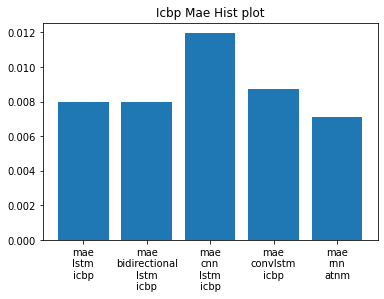

In [171]:
plot_metriks(mae_icbp_plot,mae_icbp + " Hist plot")

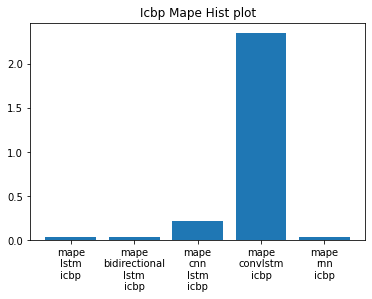

In [172]:
plot_metriks(mape_icbp_plot,mape_icbp + " Hist plot")

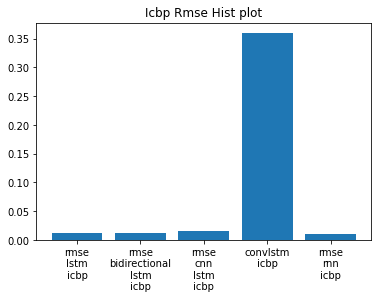

In [173]:
plot_metriks(rmse_icbp_plot,rmse_icbp + " Hist plot")

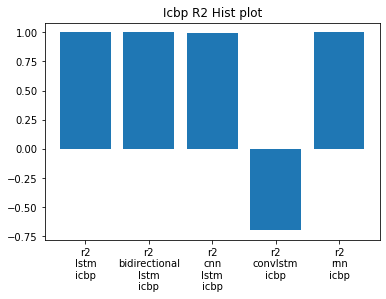

In [174]:
plot_metriks(r2_icbp_plot,r2_icbp +" Hist plot")

#### JSMR

In [175]:
mae_jsmr_plot = {'mae\nlstm\njsmr':mean_absolute_error(preds_jsmr, y_test_jsmr),'mae\nbidirectional\nlstm\njsmr':mean_absolute_error(preds_jsmr_bidirectional, y_test_jsmr),'mae\ncnn\nlstm\njsmr':mean_absolute_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mae\nconvlstm\njsmr':mean_absolute_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mae\nrnn\natnm':mean_absolute_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

mape_jsmr_plot = {'mape\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr, y_test_jsmr),'mape\nbidirectional\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_bidirectional, y_test_jsmr),'mape\ncnn\nlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'mape\nconvlstm\njsmr':mean_absolute_percentage_error(preds_jsmr_conv_lstm, y_test_jsmr_conv),'mape\nrnn\njsmr':mean_absolute_percentage_error(preds_jsmr_rnn, y_test_jsmr_rnn)}

rmse_jsmr_plot = {'rmse\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr, y_test_jsmr)),'rmse\nbidirectional\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_bidirectional, y_test_jsmr)),'rmse\ncnn\nlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_cnn_lstm, y_test_jsmr_cnn)),'convlstm\njsmr':np.sqrt(mean_squared_error(preds_jsmr_conv_lstm, y_test_jsmr_conv)),'rmse\nrnn\njsmr':np.sqrt(mean_squared_error(preds_jsmr_rnn, y_test_jsmr_rnn))}

r2_jsmr_plot = {'r2\nlstm\njsmr':r2_score(preds_jsmr, y_test_jsmr),'r2\nbidirectional\nlstm\njsmr':r2_score(preds_jsmr_bidirectional, y_test_jsmr),'r2\ncnn\nlstm\njsmr':r2_score(preds_jsmr_cnn_lstm, y_test_jsmr_cnn),'r2\nconvlstm\njsmr':r2_score(preds_jsmr_conv_lstm, y_test_jsmr_conv),'r2\nrnn\njsmr':r2_score(preds_jsmr_rnn, y_test_jsmr_rnn)} 


In [176]:
mae_jsmr = 'Jsmr Mae'
mape_jsmr = 'Jsmr Mape'
rmse_jsmr = 'Jsmr Rmse'
r2_jsmr = 'Jsmr R2'

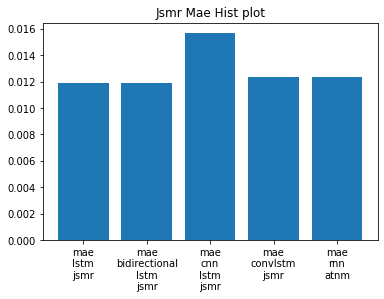

In [177]:
plot_metriks(mae_jsmr_plot,mae_jsmr + " Hist plot")

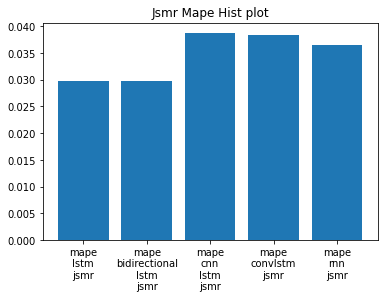

In [178]:
plot_metriks(mape_jsmr_plot,mape_jsmr + " Hist plot")

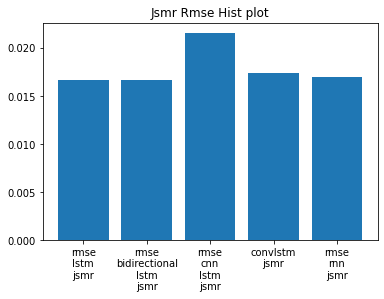

In [179]:
plot_metriks(rmse_jsmr_plot,rmse_jsmr + " Hist plot")

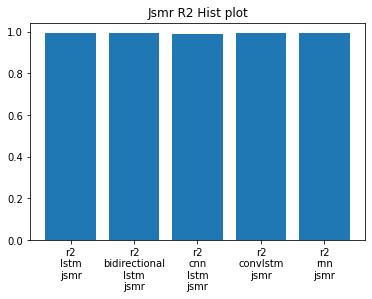

In [180]:
plot_metriks(r2_jsmr_plot,r2_jsmr +" Hist plot")